# TP06 Dask Array
# Distance de Levenstein

La distance de Levenshtein est une métrique permettant de mesurer la différence entre deux séquences de caractères. Cette distance correspond au nombre minimal d'opérations élémentaires (insertion, suppression ou substitution de caractères) nécessaires pour transformer une séquence en une autre.

Par exemple, la distance entre `sitting` et `kitten` est de 3 (2 substitutions, 1 suppression).

Formellement, la distance peut être définie de manière récursive selon la définition suivante où pour une chaîne de caractères $s$, $|s|$ représente sa longueur et $s-1$ désigne la chaîne $s$ sans son premier caractère.
$$
\qquad\operatorname{lev}(a,b) = 
\begin{cases}
  \max(|a|,|b|) & \text{ si } \min(|a|,|b|)=0, \\
  \operatorname{lev}(a-1,b-1) & \text{ si } a[0]=b[0], \\
  1 + \min \begin{cases}
          \operatorname{lev}(a-1,b)\\
          \operatorname{lev}(a,b-1)\\
          \operatorname{lev}(a-1,b-1)
       \end{cases} & \text{ sinon.}
\end{cases}
$$

À partir de cette définition, il en résulte un algorithme itératif dynamique naïf permettant de calculer la distance de Levenshtein entre deux séquences en remplissant une matrice de coûts (matrice d'édition).

L’objectif de cet exercice est d’établir un algorithme distribué du calcul de la distance de Levenshtein et, si possible, de le mettre en oeuvre avec Dask

In [19]:
import numpy as np
import dask.array as da
import time
import matplotlib.pyplot as plt

In [2]:
from numba import njit

In [3]:
def initialize_matrix(s1, s2):
    """Initialisation de la matrice d'édition avec les bords (insertions/suppressions)."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = np.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = np.arange(n+1)  # Première ligne : Insertions

    return dp

In [4]:
def fill_matrix(dp, s1, s2):
    """Remplissage la matrice de Levenshtein (approche dynamique)"""
    m, n = len(s1), len(s2)

    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i, j] = min(
                dp[i-1, j] + 1,      # Suppression
                dp[i, j-1] + 1,      # Insertion
                dp[i-1, j-1] + cost  # Substitution
            )

In [5]:
def levenshtein_numpy(s1, s2):
    """Calcul de la distance levenshtein."""
    dp = initialize_matrix(s1, s2)  # Initialisation de la matrice
    fill_matrix(dp, s1, s2)         # Remplissage de la matrice

    return dp[len(s1), len(s2)]     # Retourne la distance finale

Escreva um algoritmo baseado neste modelo de distancia levenstein, mas onde a matriz principal é preenchida percorrendo bloco a bloco de tamanho fixo 100x100. é preenchido um bloco e depois passa ao seguinte linha por linha.

def initialize_matrix(s1, s2):
    """Initialisation de la matrice d'édition avec les bords (insertions/suppressions)."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale
    dp = np.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = np.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = np.arange(n+1)  # Première ligne : Insertions

    return dp

def fill_matrix(dp, s1, s2):
    """Remplissage la matrice de Levenshtein (approche dynamique)"""
    m, n = len(s1), len(s2)

    for i in range(1, m+1):
        for j in range(1, n+1):
            cost = 0 if s1[i-1] == s2[j-1] else 1
            dp[i, j] = min(
                dp[i-1, j] + 1,      # Suppression
                dp[i, j-1] + 1,      # Insertion
                dp[i-1, j-1] + cost  # Substitution
            )

def levenshtein_numpy(s1, s2):
    """Calcul de la distance levenshtein."""
    dp = initialize_matrix(s1, s2)  # Initialisation de la matrice
    fill_matrix(dp, s1, s2)         # Remplissage de la matrice

    return dp[len(s1), len(s2)]     # Retourne la distance finale

### Test

In [6]:
s1 = "GATTACA"
s2 = "GCATGCU"
print(levenshtein_numpy(s1, s2))  

4


## 1. Version naïve.
1. Tester l’algorithme sur différentes séquences en augmentant la taille des séquences et relever les temps de restitution.

In [27]:
seq1 = ['GATTACA', 'flawn', 'sitting', 'saturday', 'elephant', 'encyclopedia', 'democracy', 'marcy', 'rodrigo']
seq2 = ['GCATGCU', 'drawn', 'kitten', 'sunday', 'relevant', 'psychoanalysis', 'aristocracy', 'andreina', 'gaston']
dists = []
np_times = []

for i in range(len(seq1)): 
    tic = time.time()
    result = levenshtein_numpy(seq1[i], seq2[i])  
    toc = time.time()
    np_times.append(toc-tic)
    dists.append(result)
    print(f'Distance = {result} calculated in {toc-tic}s')

Distance = 4 calculated in 6.961822509765625e-05s
Distance = 2 calculated in 9.5367431640625e-05s
Distance = 3 calculated in 2.5987625122070312e-05s
Distance = 3 calculated in 2.86102294921875e-05s
Distance = 3 calculated in 3.886222839355469e-05s
Distance = 11 calculated in 9.608268737792969e-05s
Distance = 5 calculated in 5.4836273193359375e-05s
Distance = 7 calculated in 3.0040740966796875e-05s
Distance = 7 calculated in 2.765655517578125e-05s


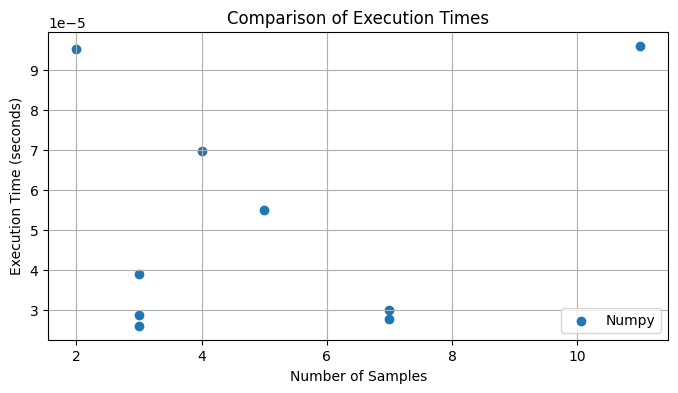

In [28]:
plt.figure(figsize=(8, 4))
plt.scatter(dists, np_times, label='Numpy', marker='o')
plt.xlabel('Distance')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times')
plt.legend()
plt.grid()
plt.show()

2. Sur la base du code existant écrire un version utilisant des dask array. 
Tester sur de petites séquences, observer le graphe des tâches et relever les temps de restitution.

Distance =  1


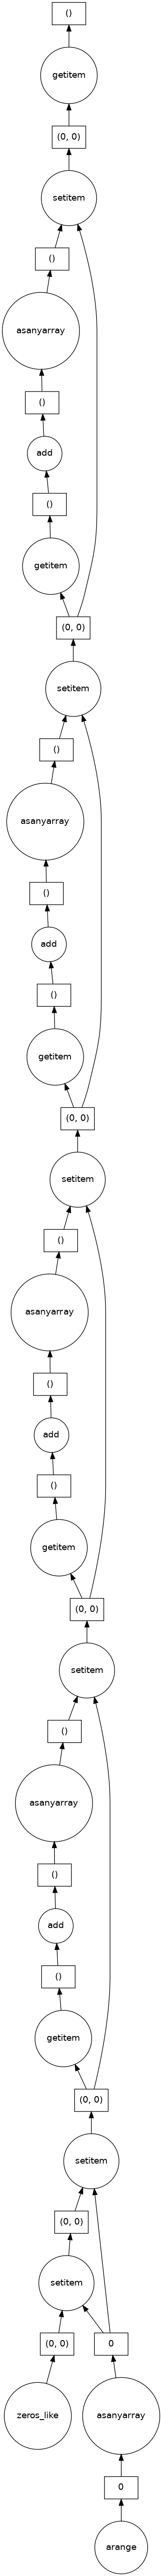

In [48]:
def initialize_matrix_da(s1, s2):
    """Initialisation de la matrice d'édition avec les bords (insertions/suppressions)."""
    m, n = len(s1), len(s2)

    # Création de la matrice principale
    dp = da.zeros((m+1, n+1), dtype=int)

    # Initialisation des bords (coûts d'insertion et suppression)
    dp[:, 0] = da.arange(m+1)  # Première colonne : Suppressions
    dp[0, :] = da.arange(n+1)  # Première ligne : Insertions

    return dp


def levenshtein_dask(s1, s2):
    """Calcul de la distance levenshtein."""
    dp = initialize_matrix_da(s1, s2)  # Initialisation de la matrice
    fill_matrix(dp, s1, s2)         # Remplissage de la matrice

    return dp[len(s1), len(s2)]     # Retourne la distance finale

s1 = "he"
s2 = "hi"
result = levenshtein_dask(s1, s2)
print("Distance = ", result.compute()) 
result.visualize() 

In [49]:
result

dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

In [39]:
seq1 = ['GATTACA', 'flawn', 'sitting', 'saturday', 'elephant', 'encyclopedia', 'democracy', 'marcy', 'rodrigo']
seq2 = ['GCATGCU', 'drawn', 'kitten', 'sunday', 'relevant', 'psychoanalysis', 'aristocracy', 'andreina', 'gaston']
dists = []
da_times = []

for i in range(len(seq1)): 
    tic = time.time()
    result = levenshtein_dask(seq1[i], seq2[i])
    result2 = result.compute() 
    toc = time.time()
    da_times.append(toc-tic)
    dists.append(result2)
    print(f'Distance = {result2} calculated in {toc-tic}s')

Distance = 4 calculated in 0.882789134979248s
Distance = 2 calculated in 0.3337123394012451s
Distance = 3 calculated in 0.75079345703125s
Distance = 3 calculated in 0.8545553684234619s
Distance = 3 calculated in 1.4242274761199951s
Distance = 11 calculated in 9.487403869628906s
Distance = 5 calculated in 3.2705881595611572s
Distance = 7 calculated in 0.6998846530914307s
Distance = 7 calculated in 0.6755914688110352s


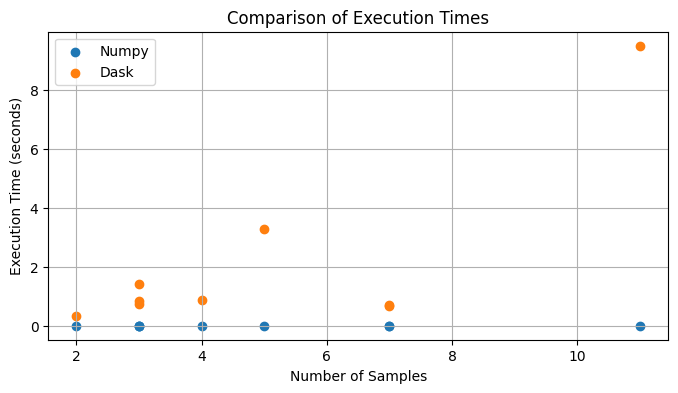

In [41]:
plt.figure(figsize=(8, 4))
plt.scatter(dists, np_times, label='Numpy', marker='o')
plt.scatter(dists, da_times, label='Dask', marker='o')
plt.xlabel('Distance')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times')
plt.legend()
plt.grid()
plt.show()

In [45]:
result

dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

## 2 Optimisations
1. Sur la base de la version numpy, écrire un algorithme non parallèle où la matrice principale est remplie en la parcourant par bloc de taille fixe (par exemple 100 $\times$ 100) : on remplit le premier bloc puis on passe au suivant ligne par ligne.

In [54]:
import numpy as np

def initialize_matrix(s1, s2):
    """Inicializa a matriz de edição com os custos de inserção e deleção."""
    m, n = len(s1), len(s2)
    dp = np.zeros((m+1, n+1), dtype=int)
    dp[:, 0] = np.arange(m+1)
    dp[0, :] = np.arange(n+1)
    return dp

def fill_matrix_blockwise(dp, s1, s2, block_size=3):
    """Preenche a matriz de Levenshtein bloco por bloco."""
    m, n = len(s1), len(s2)
    
    for block_i in range(1, m+1, block_size):
        for block_j in range(1, n+1, block_size):
            
            # Definir os limites do bloco
            max_i = min(block_i + block_size, m + 1)
            max_j = min(block_j + block_size, n + 1)
            
            for i in range(block_i, max_i):
                for j in range(block_j, max_j):
                    cost = 0 if s1[i-1] == s2[j-1] else 1
                    dp[i, j] = min(
                        dp[i-1, j] + 1,      # Deleção
                        dp[i, j-1] + 1,      # Inserção
                        dp[i-1, j-1] + cost  # Substituição
                    )

def levenshtein_blockwise(s1, s2, block_size=3):
    """Calcula a distância de Levenshtein utilizando preenchimento em blocos."""
    dp = initialize_matrix(s1, s2)
    fill_matrix_blockwise(dp, s1, s2, block_size)
    return dp[len(s1), len(s2)]


s1 = "GATTACA"
s2 = "GCATGCU"
print(levenshtein_blockwise(s1, s2))  

4


2. Relever les temps de restitution.

In [64]:
dists = []
bl_times = []

for i in range(len(seq1)): 
    tic = time.time()
    result = levenshtein_blockwise(seq1[i], seq2[i])  
    toc = time.time()
    bl_times.append(toc-tic)
    dists.append(result)
    print(f'Distance = {result} calculated in {toc-tic}s')

Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 0.8764121532440186s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 0.27964329719543457s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 0.6662442684173584s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 0.9409492015838623s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 1.4238958358764648s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 9.783992767333984s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 3.3823530673980713s
Distance = dask.array<getitem, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> calculated in 0.60

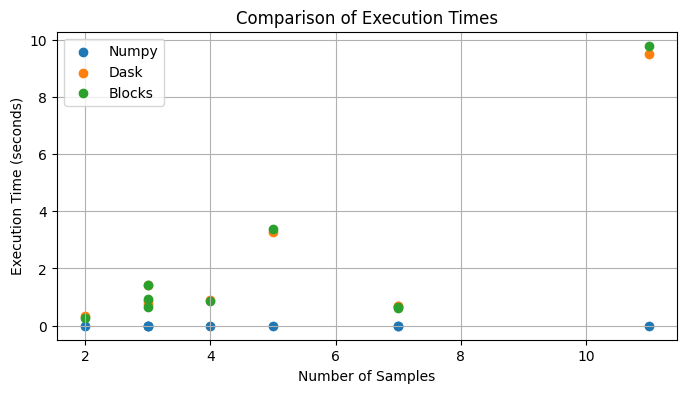

In [65]:
plt.figure(figsize=(8, 4))
plt.scatter(dists, np_times, label='Numpy', marker='o')
plt.scatter(dists, da_times, label='Dask', marker='o')
plt.scatter(dists, bl_times, label='Blocks', marker='o')
plt.xlabel('Distance')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times')
plt.legend()
plt.grid()
plt.show()

3. Sur la base de cette version établir un algorithme parallèle et tenter de le mettre en oeuvre à l’aide de Dask array, pour cela regarder les méthodes `map_blocks` et `map_overlap`.

In [66]:
import numpy as np
import dask.array as da

def initialize_matrix(s1, s2):
    """Inicializa a matriz de edição com os custos de inserção e deleção."""
    m, n = len(s1), len(s2)
    dp = np.zeros((m+1, n+1), dtype=int)
    dp[:, 0] = np.arange(m+1)
    dp[0, :] = np.arange(n+1)
    return da.from_array(dp, chunks=(min(100, m+1), min(100, n+1)))

def compute_block(block, s1=None, s2=None, block_offset=None):
    """Computa um bloco da matriz de Levenshtein."""
    max_int = np.iinfo(np.int32).max
    block_i, block_j = block_offset
    
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            abs_i, abs_j = block_i + i, block_j + j
            if abs_i == 0 or abs_j == 0:
                continue
            
            cost = 0 if s1[abs_i-1] == s2[abs_j-1] else 1
            block[i, j] = min(
                block[i-1, j] + 1 if i > 0 else max_int,      # Deleção
                block[i, j-1] + 1 if j > 0 else max_int,      # Inserção
                block[i-1, j-1] + cost if i > 0 and j > 0 else max_int  # Substituição
            )
    return block

def fill_matrix_parallel(dp, s1, s2, block_size=100):
    """Preenche a matriz de Levenshtein de forma paralela com Dask."""
    return dp.map_blocks(compute_block, dtype=int, s1=s1, s2=s2, block_offset=(0, 0))

def levenshtein_parallel(s1, s2, block_size=100):
    """Calcula a distância de Levenshtein utilizando preenchimento em blocos de forma paralela."""
    dp = initialize_matrix(s1, s2)
    dp = fill_matrix_parallel(dp, s1, s2, block_size)
    return dp.compute()[-1, -1]


In [67]:
s1 = "GATTACA"
s2 = "GCATGCU"
print(levenshtein_parallel(s1, s2))  

4


4. Relever les temps de restitution

In [68]:
dists = []
pa_times = []

for i in range(len(seq1)): 
    tic = time.time()
    result = levenshtein_parallel(seq1[i], seq2[i])  
    toc = time.time()
    pa_times.append(toc-tic)
    dists.append(result)
    print(f'Distance = {result} calculated in {toc-tic}s')

Distance = 4 calculated in 0.003515005111694336s
Distance = 2 calculated in 0.002167224884033203s
Distance = 3 calculated in 0.0021812915802001953s
Distance = 3 calculated in 0.0020062923431396484s
Distance = 3 calculated in 0.002323627471923828s
Distance = 11 calculated in 0.003101825714111328s
Distance = 5 calculated in 0.0018799304962158203s
Distance = 7 calculated in 0.0017216205596923828s
Distance = 7 calculated in 0.001764535903930664s


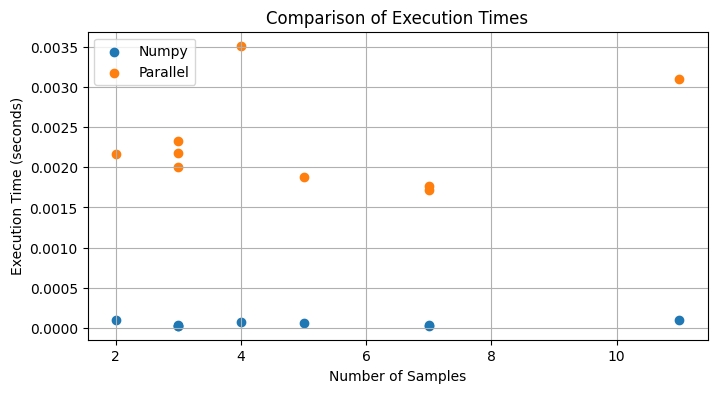

In [71]:
plt.figure(figsize=(8, 4))
plt.scatter(dists, np_times, label='Numpy', marker='o')
# plt.scatter(dists, da_times, label='Dask', marker='o')
# plt.scatter(dists, bl_times, label='Blocks', marker='o')
plt.scatter(dists, pa_times, label='Parallel', marker='o')
plt.xlabel('Distance')
plt.ylabel('Execution Time (seconds)')
plt.title('Comparison of Execution Times')
plt.legend()
plt.grid()
plt.show()